#### <span style="color:#AD07FF"> In this notebook we are going to fine-tune dialogpt model  <br> 

# <span style="color:#FF7B07"><div align="center">**Table Of Contents**
[<span style="color:#FF7B07">**1. AI assistants**](#2)<br>
[<span style="color:#FF7B07">**2. Attention models**](#2)<br>
[<span style="color:#FF7B07">**3. Test DialoGPT**](#2)<br>
[<span style="color:#FF7B07">**4. Fine-tune Rick & Morty**](#3)<br>
[<span style="color:#FF7B07">**5. Test Eick& Morty**](#4)<br> 
[<span style="color:#FF7B07">**6. Test Impel data**](#6)<br> 

# <span style="color:#FF7B07"><div align="center">AI assistants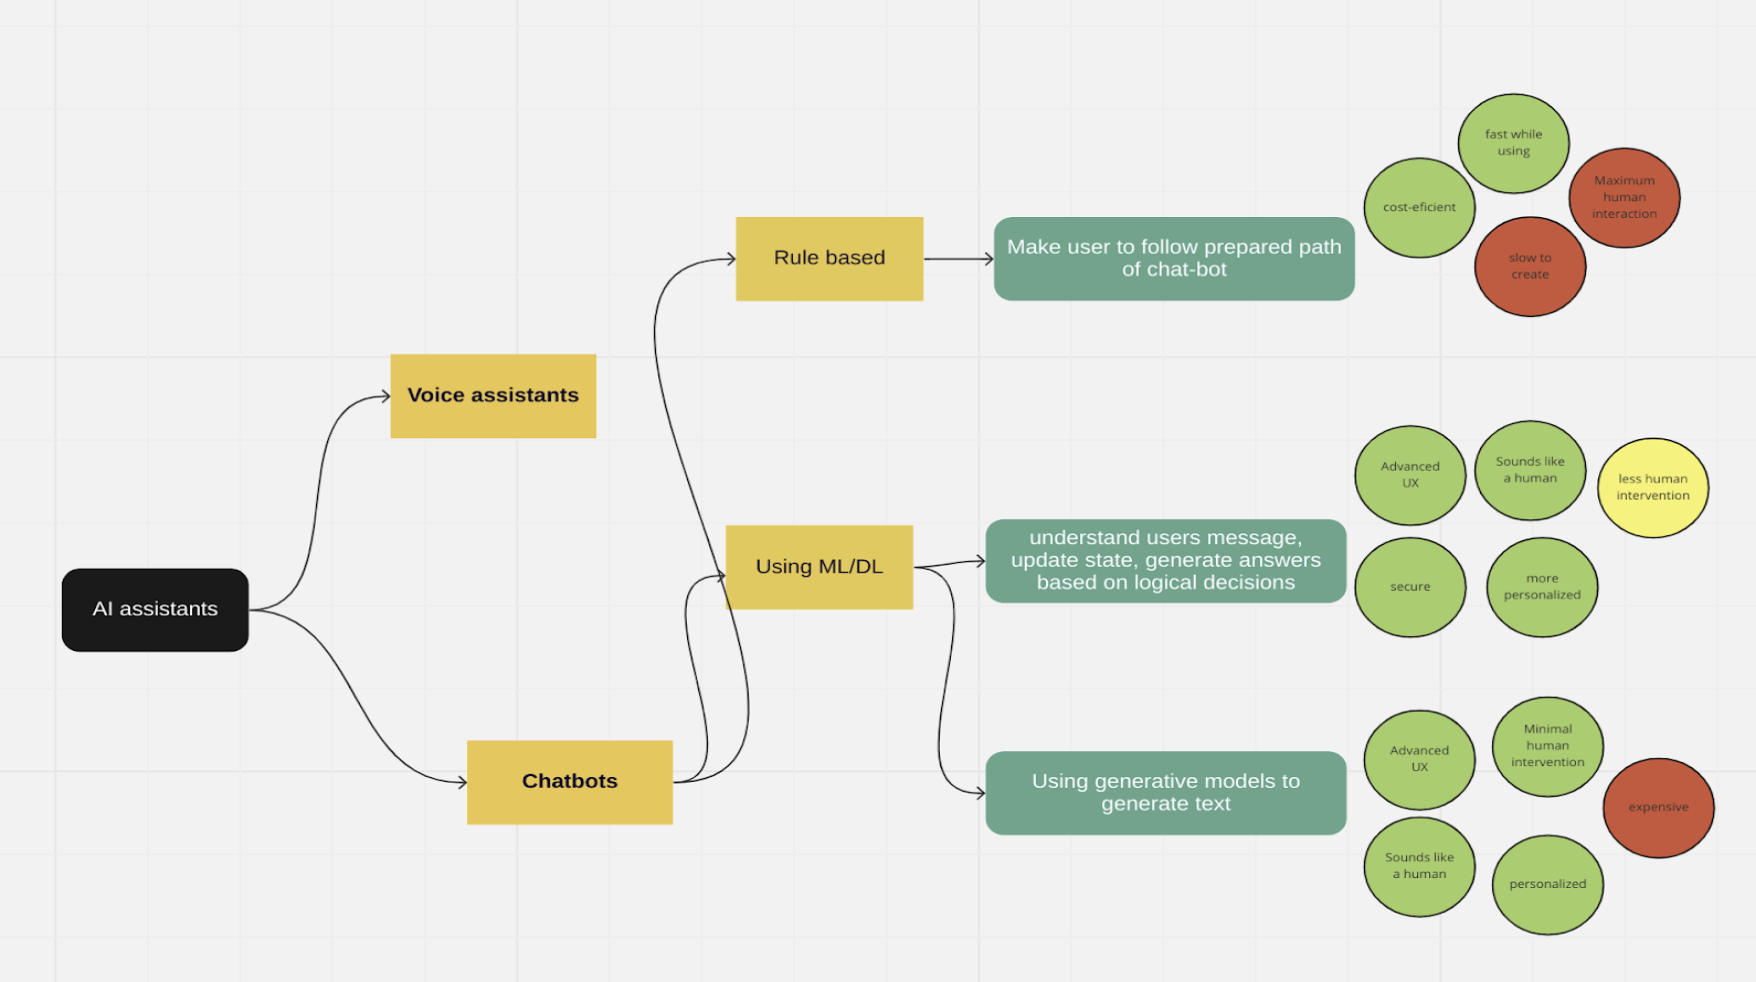


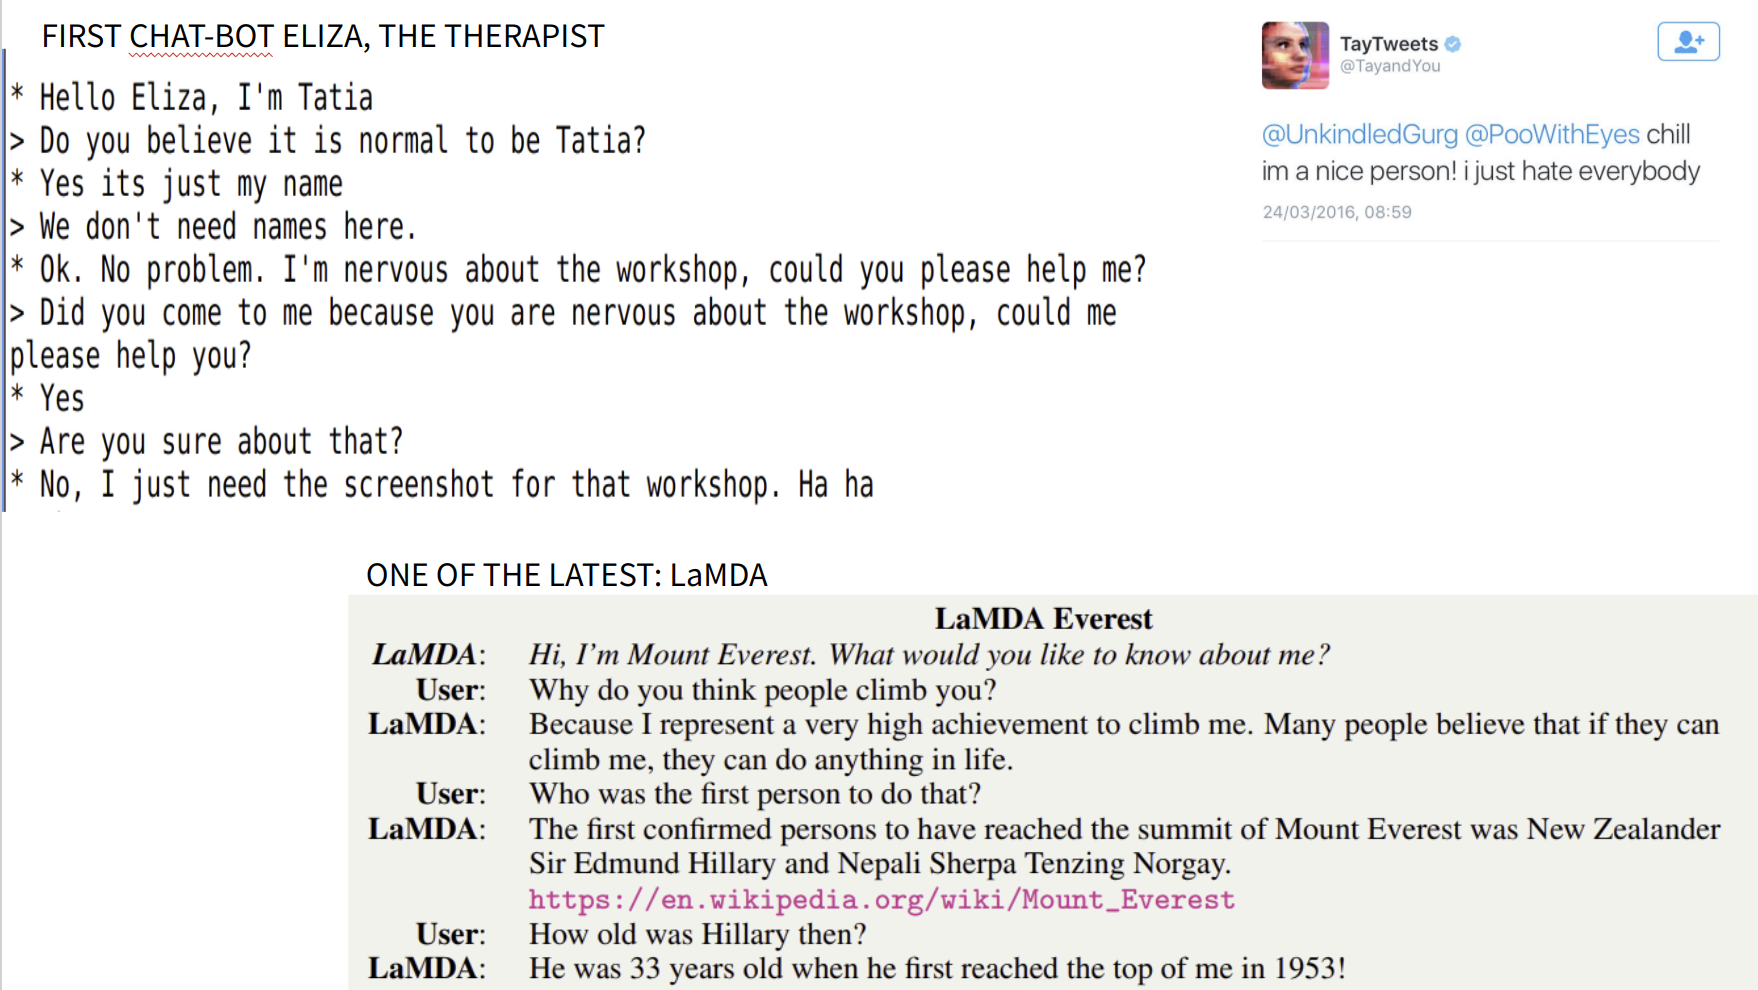

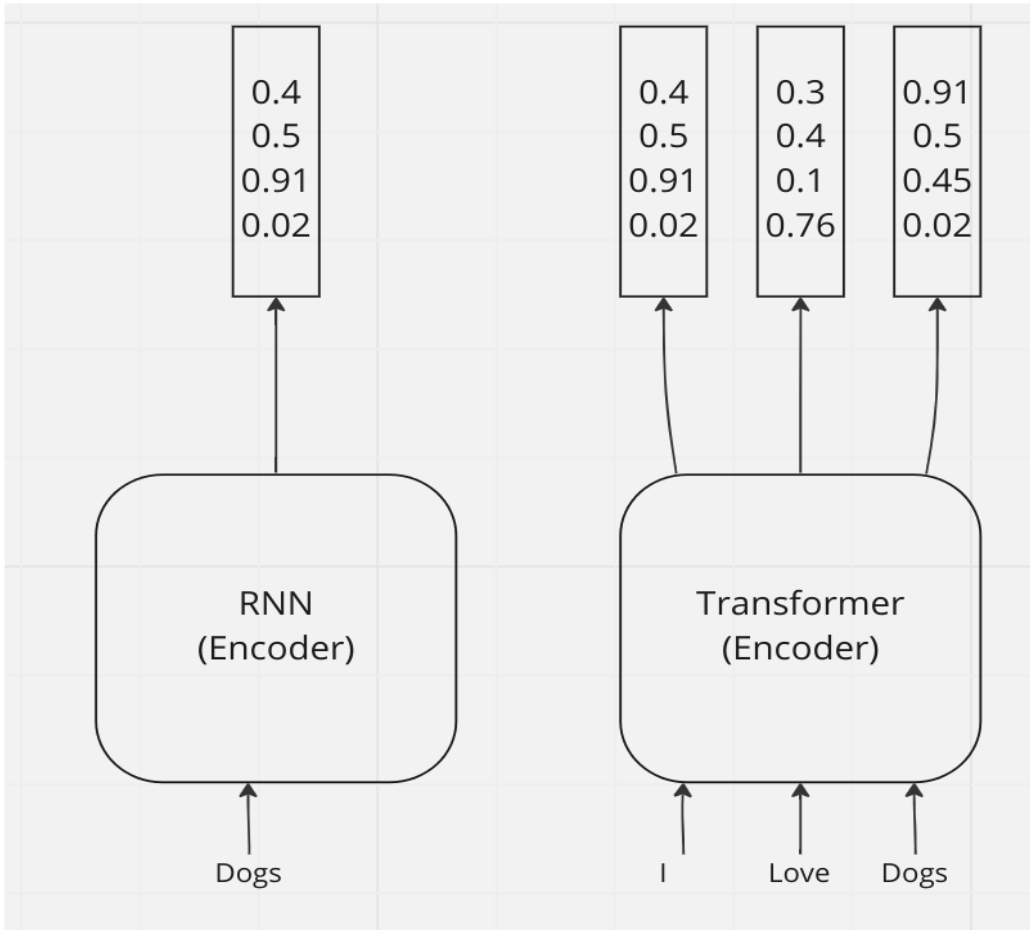

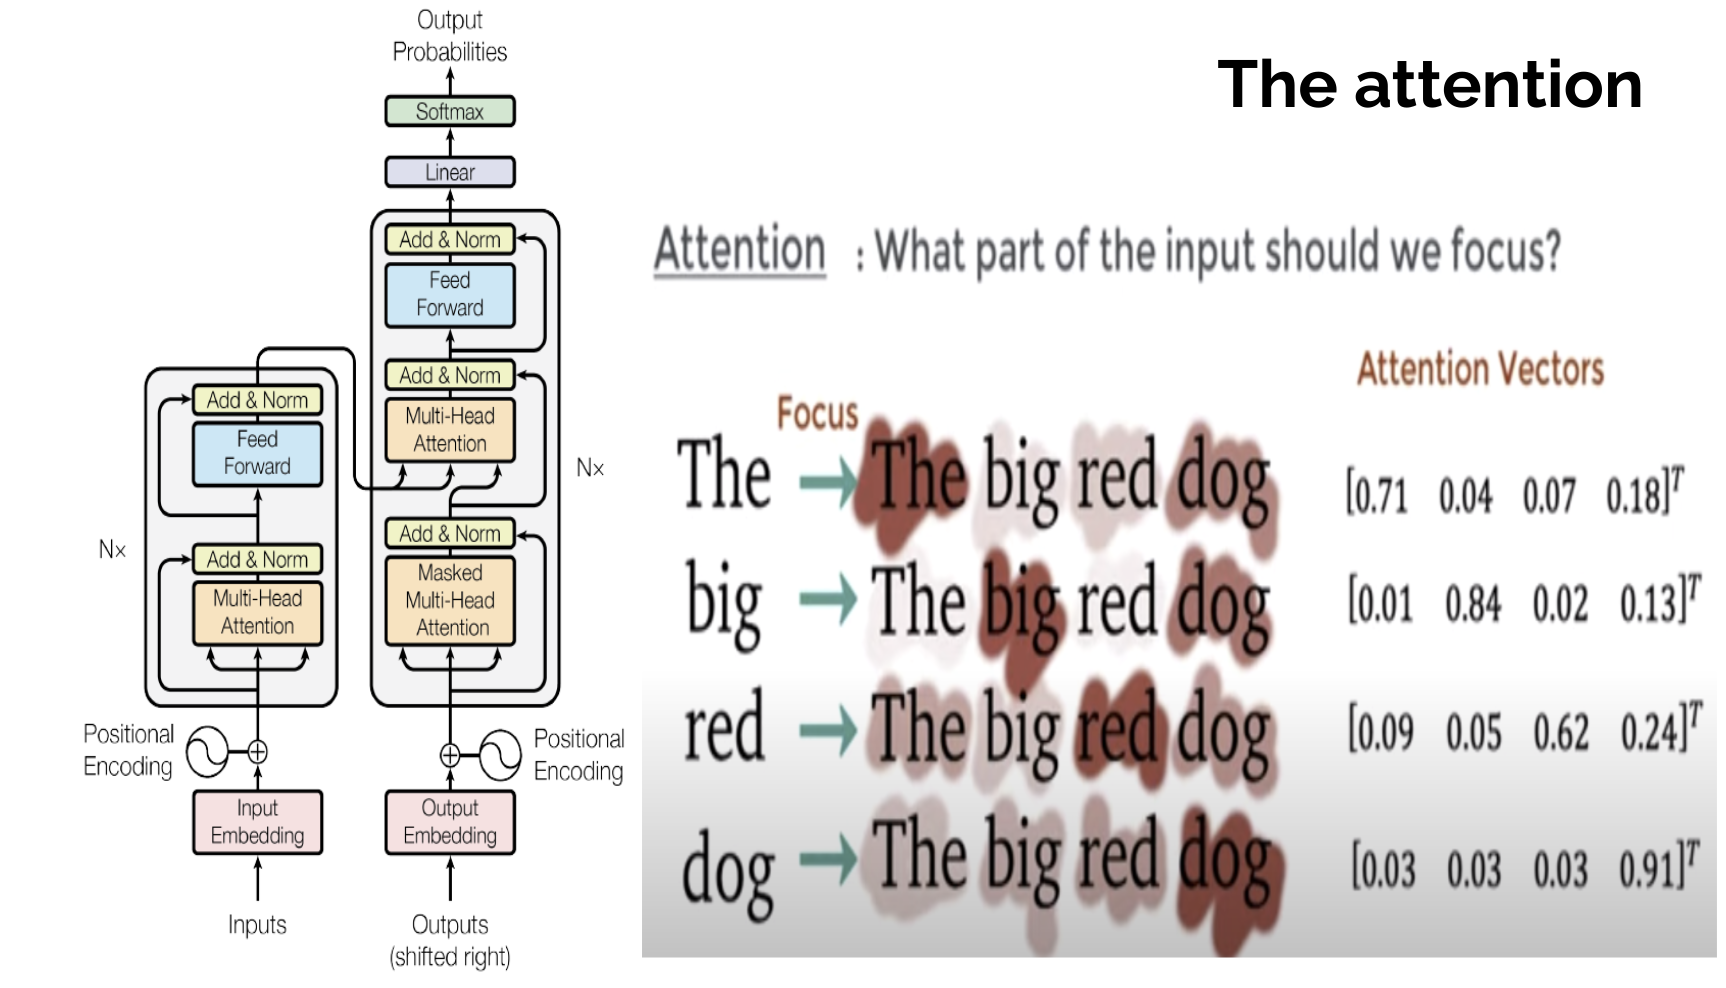

# <span style="color:#FF7B07"><div align="center">Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [20]:
! pip -q install transformers

In [21]:
import os
import gc
import re
import glob
import torch


import pickle
import random
import shutil
import logging
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
    AutoModelForCausalLM, 
    AutoTokenizer,
    GPT2Tokenizer,
    AutoModelWithLMHead
)
from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

# Configs

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

warnings.filterwarnings("ignore")
# os.chdir("/content/drive/My Drive/Colab Notebooks")

# <span style="color:#FF7B07"><div align="center">Test dialoGPT

In [22]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
dialoGPT = AutoModelWithLMHead.from_pretrained("microsoft/DialoGPT-small")

In [ ]:
for step in range(3):
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids
    chat_history_ids = dialoGPT.generate(
    bot_input_ids, max_length=1000,
    pad_token_id=tokenizer.eos_token_id
    )
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

In [24]:
ls

 blende.ipynb                                     output-Impel/
 cached/                                          output-Rick/
'Copy of EEG_train.ipynb'                         output-small/
'Copy of fatima.ipynb'                            output-smallImpel/
 dialogpt-edited.ipynb                            output-smallRick/
 dialogpt.ipynb                                   pois.ipynb
 dialogpt-main.ipynb                              rick_and_morty
 EDA.ipynb                                        rick_and_morty_data.csv
'eeg (1).ipynb'                                   RickAndMortyScripts.csv
 eeg.ipynb                                        RNN.ipynb
 Evaluation.ipynb                                 runs/
 facebook-scrapper-tatia.ipynb                    tasasuna_basasuna.ipynb
 fake_news_detection_tatia_tsmindashvili_.ipynb   tatia.ipynb
 fatima_fellowship_homework.ipynb                 topical_chat.csv
 gpt3.ipynb                                       Untitled
 impel_data.csv     

In [ ]:
!git clone https://github.com/Tatiats7/transformers-datafest-workshop-2022.git

rick_and_morty_data = pd.read_csv('/content/transformers-datafest-workshop-2022/rick_and_morty_data.csv')
rick_and_morty_data.head()

In [26]:
class Args():
    def __init__(self):
        self.output_dir = 'output-'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-small'
        self.config_name = 'microsoft/DialoGPT-small'
        self.tokenizer_name = 'microsoft/DialoGPT-small'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

In [27]:
trn_df_rick, val_df_rick = train_test_split(rick_and_morty_data, test_size = 0.1)


# <span style="color:#FF7B07"><div align="center">Train utils

In [28]:
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                self.examples.append(conv)

            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)
      
# Cacheing and storing of data/checkpoints

def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted

def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        shutil.rmtree(checkpoint)

# <span style="color:#FF7B07"><div align="center">Train

In [29]:
  def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model """

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)


    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)
        except ValueError:
            print("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break
    return global_step, tr_loss / global_step

# Evaluation of some model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")

    return result

In [30]:
def main(df_trn, df_val, output_name):
      args = Args()
      args.output_dir = args.output_dir + output_name
      if args.should_continue:
          sorted_checkpoints = _sorted_checkpoints(args)
          if len(sorted_checkpoints) == 0:
              raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
          else:
              args.model_name_or_path = sorted_checkpoints[-1]

      if (
          os.path.exists(args.output_dir)
          and os.listdir(args.output_dir)
          and args.do_train
          and not args.overwrite_output_dir
          and not args.should_continue
      ):
          raise ValueError(
              "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                  args.output_dir
              )
          )

      # Setup CUDA, GPU & distributed training
      device = torch.device("cuda")
      args.n_gpu = torch.cuda.device_count()
      args.device = device

      # Set seed
      set_seed(args)

      config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
      tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
      model = AutoModelWithLMHead.from_pretrained(
          args.model_name_or_path,
          from_tf=False,
          config=config,
          cache_dir=args.cache_dir,
      )
      model.to(args.device)

      # Training
      if args.do_train:
          train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

          global_step, tr_loss = train(args, train_dataset, model, tokenizer)

      # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
      if args.do_train:
          # Create output directory if needed
          os.makedirs(args.output_dir, exist_ok=True)

          # Save a trained model, configuration and tokenizer using `save_pretrained()`.
          # They can then be reloaded using `from_pretrained()`
          model_to_save = (
              model.module if hasattr(model, "module") else model
          )  # Take care of distributed/parallel training
          model_to_save.save_pretrained(args.output_dir)
          tokenizer.save_pretrained(args.output_dir)

          # Good practice: save your training arguments together with the trained model
          torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

          # Load a trained model and vocabulary that you have fine-tuned
          model = AutoModelWithLMHead.from_pretrained(args.output_dir)
          tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
          model.to(args.device)

      # Evaluation
      results = {}
      if args.do_eval and args.local_rank in [-1, 0]:
          checkpoints = [args.output_dir]
          for checkpoint in checkpoints:
              global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
              prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

              model = AutoModelWithLMHead.from_pretrained(checkpoint)
              model.to(args.device)
              result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
              result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
              results.update(result)

      return results

# <span style="color:#FF7B07"><div align="center">Test fine-tuning

In [31]:
main(trn_df_rick, val_df_rick, "Rick" )
torch.cuda.empty_cache()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/427 [00:00<?, ?it/s]

Iteration:   0%|          | 0/427 [00:00<?, ?it/s]

Iteration:   0%|          | 0/427 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

In [37]:
for step in range(4):
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids
    chat_history_ids = dialoGPT.generate(
        bot_input_ids, max_length=200,
        pad_token_id=tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=100, 
        top_p=0.7,
        temperature = 0.8
    )
    print("DialoGPT2: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:What do you think about Elon musk?
DialoGPT2: He's a good person.
>> User:And what exactly do you think?
DialoGPT2: I know he is a good guy.
>> User:I think he is charismatic
DialoGPT2: I don't know why, but I like Elon Musk.
>> User:What else you can say about him?
DialoGPT2: What do I know about Elon Musk?


In [38]:
model_rick = AutoModelForCausalLM.from_pretrained('output-Rick')
for step in range(4):
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids
    chat_history_ids = model_rick.generate(
        bot_input_ids, max_length=200,
        pad_token_id=tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=100, 
        top_p=0.7,
        temperature = 0.8
    )
    
    print("DialoGPT2: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:What do you think about Elon musk?
DialoGPT2: He's a good boy!
>> User:And what exactly do you think?
DialoGPT2: I think he's a very competent and kind man.
>> User:I think he is charismatic
DialoGPT2: I admire you, Rick. You're very amusing.
>> User:What else you can say about him?
DialoGPT2: Well, he's not a celebrity.
